In [ ]:
!pip install -q git+https://github.com/DataScienceUWL/DS776.git#subdirectory=introdl

Obtaining file:///C:/Users/bagge/My%20Drive/Python_Projects/DS776_Develop_Project/DS776/introdl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for introdl (pyproject.toml): started
  Building editable for introdl (pyproject.toml): finished with status 'done'
  Created wheel for introdl: filename=introdl-1.0-0.editable-py3-none-any.whl size=1329 sha256=f7136e53f1e45e7dc87087360d512c4926a4eca4413dec48239ad6ffd34f4d21
  Stored in directory: C:\Users\bagge\AppData\Local\Temp\pip-ephem-wheel-cache-kyyw4phh\wheels\15\92\1d\ab97b6e7

# Segmentation using UNET

In [15]:
import os
import random
from pathlib import Path

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from dotenv import load_dotenv
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import segmentation_models_pytorch as smp

from introdl.idlmam import train_network
from introdl.utils import get_device, load_model

# Load environment variables (change .env file in parent directory to change these)
ENV_FILE = Path("..") / ".env_home"
load_dotenv(ENV_FILE)

DATA_PATH = Path(os.getenv('DATA_PATH').strip('"').strip("'"))
MODELS_PATH = Path(os.getenv('MODELS_PATH').strip('"').strip("'"))
os.environ['TORCH_HOME'] = os.getenv('TORCH_HOME').strip('"').strip("'")

# Using Segmentation Models Pytorch Package

In [13]:
class PennFudanSegmentDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.root = Path(root)
        self.split = split
        self.transform = transform

        # Define the image and mask directories based on the split
        self.image_dir = self.root / split / "images"
        self.mask_dir = self.root / split / "masks"

        # Load and sort all image and mask file names
        self.images = sorted(self.image_dir.iterdir())
        self.masks = sorted(self.mask_dir.iterdir())

        # Ensure that the number of images and masks match
        assert len(self.images) == len(self.masks), "Mismatch between images and masks count."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask paths
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert mask to binary format (0 or 1) and to float for compatibility
        mask = np.array(mask)
        mask = np.where(mask > 0, 1, 0).astype(np.float32)

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)  # Add channel dimension for mask

        return image, mask

# Define transformations using Albumentations for training and validation
train_transform = A.Compose([
    A.Resize(height=256, width=256),  # Resize to a slightly larger size
    A.Rotate(limit=10, p=0.5, border_mode=0),  # Rotate up to ±10 degrees with 50% chance
    A.RandomCrop(height=224, width=224),  # Randomly crop to target size
    A.HorizontalFlip(p=0.5),  # Flip horizontally with a 50% chance
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.5),  # Color jitter only for image
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
    ToTensorV2()  # Convert to PyTorch tensor
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create dataset instances for training and validation with their respective transforms
root_dir = DATA_PATH / "PennFudanPed"
train_dataset = PennFudanSegmentDataset(root=root_dir, split="train", transform=train_transform)
val_dataset = PennFudanSegmentDataset(root=root_dir, split="val", transform=val_transform)

# Set up the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
def overlay_masks(image, mask, color, thickness=1):
    """
    Overlay a binary mask outline on an image.

    Parameters:
    - image (numpy.ndarray): The image on which to overlay the mask.
    - mask (numpy.ndarray): The binary mask (1 for mask, 0 for background).
    - color (tuple): The color for the mask outline in (B, G, R) format.

    Returns:
    - image (numpy.ndarray): The image with the mask outline overlaid.
    """
    mask = (mask > 0.5).astype(np.uint8)
    if len(mask.shape) > 2:
        mask = mask.squeeze()  # Ensure single-channel mask

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, color, thickness)
    return image

def denormalize(image, mean, std):
    """Reverse normalization for visualization."""
    mean = np.array(mean)
    std = np.array(std)
    return (image * std + mean).clip(0, 1)

def display_images_and_masks(dataset, num_samples=3, model=None, indices=None, figsize=(4, 4), overlay=True, 
                             denormalize=True, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Display random samples from the dataset with ground truth masks. If a model is provided, it also displays predicted masks.

    Parameters:
    - dataset: The dataset containing the images and ground truth masks.
    - num_samples: The number of random samples to display (default: 3).
    - model: The segmentation model. If None, only ground truth masks are displayed.
    - indices (list, optional): The indices of the samples to display. If None, random samples will be selected.
    - figsize (tuple, optional): The size of the display figure (default: (6, 6)).
    - overlay (bool, optional): If True, overlays the mask on the image. If False, displays image and mask side-by-side.
    - denormalize (bool, optional): If True, denormalizes the images before displaying (default: False).
    """
    if indices is None:
        indices = random.sample(range(len(dataset)), num_samples)
    
    device = None
    if model is not None:
        model.eval()
        device = next(model.parameters()).device

    for idx in indices:
        # Load the image and ground truth mask
        image, target_mask = dataset[idx]
        
        # Move image to device for model prediction
        pred_mask = None
        if model is not None:
            image_for_model = image.to(device)
            with torch.no_grad():
                logits = model(image_for_model.unsqueeze(0))[0].squeeze().cpu()
                pred_mask = torch.sigmoid(torch.tensor(logits)).numpy()

        # Convert image to numpy and optionally denormalize
        img_np = image.permute(1, 2, 0).cpu().numpy() if device else image.permute(1, 2, 0).numpy()
        if denormalize:
            img_np = denormalize(img_np, mean, std)
        img_np = (img_np * 255).astype(np.uint8)  # Scale for OpenCV display

        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        gt_mask = target_mask.cpu().numpy() if device else target_mask.numpy()

        if overlay:
            # Overlay ground truth mask in blue
            img_overlay = overlay_masks(img_bgr.copy(), gt_mask, color=(255, 0, 0))
            
            # Overlay predicted mask in orange if model is provided
            if pred_mask is not None:
                pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize predicted mask
                img_overlay = overlay_masks(img_overlay, pred_mask, color=(0, 165, 255))

            img_rgb_overlay = cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=figsize)
            plt.imshow(img_rgb_overlay)
            plt.axis('off')
            plt.show()

        else:
            # Prepare separate images for side-by-side display
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            mask_rgb = (gt_mask.squeeze() * 255).astype(np.uint8)
            mask_rgb = np.stack([mask_rgb] * 3, axis=-1)  # Convert to 3-channel grayscale
            
            images = [img_rgb, mask_rgb]
            titles = ['Image', 'Ground Truth Mask']
            
            # Add predicted mask if model is provided
            if pred_mask is not None:
                pred_rgb = (pred_mask * 255).astype(np.uint8)  # Display as binary mask in grayscale
                pred_rgb = np.stack([pred_rgb] * 3, axis=-1)  # Convert to 3-channel grayscale
                images.append(pred_rgb)
                titles.append('Predicted Mask')
            
            plt.figure(figsize=(figsize[0] * len(images), figsize[1]))
            for i, (title, img) in enumerate(zip(titles, images)):
                plt.subplot(1, len(images), i + 1)
                plt.imshow(img)
                plt.title(title)
                plt.axis('off')
            plt.show()


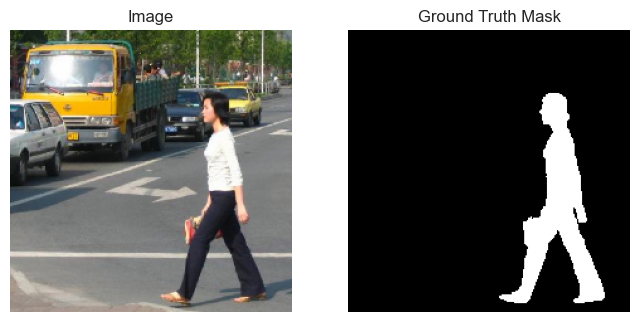

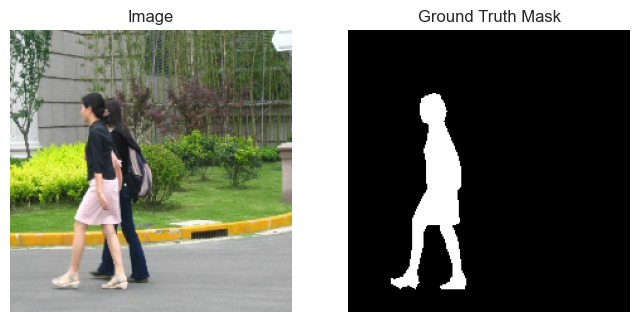

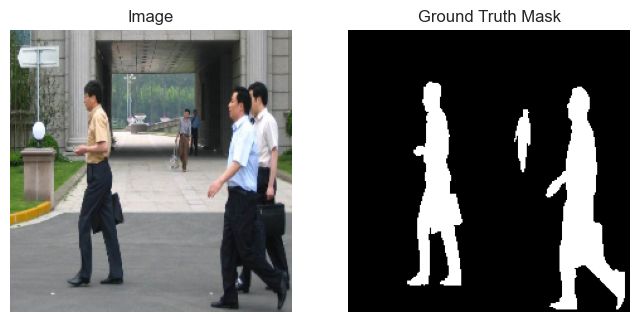

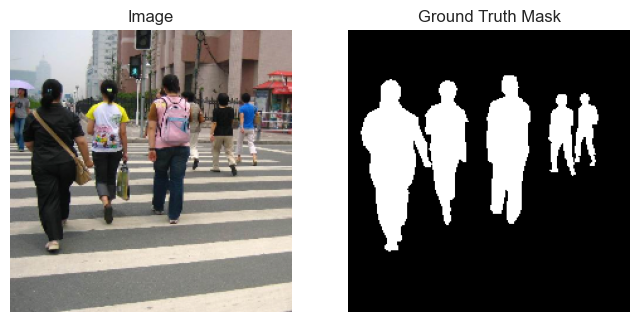

In [5]:
selected_images = [4,0,1,13]
display_images_and_masks(val_dataset, overlay=False, indices = selected_images)

In binary segmentation, **Intersection over Union (IoU)** is a metric used to measure the overlap between the predicted segmentation mask and the ground truth mask. IoU, also called the **Jaccard Index**, evaluates how well the predicted mask matches the actual object or region of interest in the image.

### How IoU Works in Binary Segmentation
1. **Binary Masks**: In binary segmentation, each pixel in the image is classified as either foreground (1) or background (0). The ground truth mask contains the actual segmentation (e.g., the region of interest), while the predicted mask is the model’s output, showing where it believes the foreground is located.

2. **Intersection and Union**:
   - **Intersection**: The number of pixels where the predicted mask and the ground truth mask both indicate foreground (1).
   - **Union**: The total number of pixels where either the predicted mask or the ground truth mask indicates foreground (1). This includes the intersection area and any areas marked as foreground in either mask.

3. **Formula**:
   $$\text{IoU} = \frac{\text{Intersection}}{\text{Union}} = \frac{|A \cap B|}{|A \cup B|}$$
   
   where:
   - $A$ is the set of pixels in the ground truth mask labeled as foreground.
   - $B$ is the set of pixels in the predicted mask labeled as foreground.

### Example Calculation
Suppose we have the following results for a single binary mask:
- **True Positives (TP)**: Pixels correctly predicted as foreground.
- **False Positives (FP)**: Pixels incorrectly predicted as foreground (should be background).
- **False Negatives (FN)**: Pixels incorrectly predicted as background (should be foreground).

Using these values, IoU can be calculated as:
$$\text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$

### Interpretation of IoU Values
- **IoU = 1**: Perfect segmentation; the predicted mask exactly matches the ground truth mask.
- **IoU = 0**: No overlap; the predicted mask does not overlap with the ground truth mask at all.
- **0 < IoU < 1**: Partial overlap; higher IoU values indicate better segmentation accuracy.

### IoU in Practice
- **Threshold for Good Segmentation**: Typically, an IoU of 0.5 or above is considered acceptable in many applications, though stricter thresholds (e.g., 0.75) are used in cases requiring high precision.
- **Challenges**: Small or thin objects may lead to lower IoU scores, as even minor misalignment can significantly impact the intersection area.

### Comparison to Dice Coefficient
IoU is closely related to the **Dice Coefficient**, which is another popular metric in segmentation:
$$\text{Dice} = \frac{2 \times \text{Intersection}}{\text{Total Pixels in Predicted Mask + Ground Truth Mask}} = \frac{2 \times |A \cap B|}{|A| + |B|}$$
While IoU emphasizes the union, Dice places more weight on the intersection area, making it slightly more forgiving for small misalignments. Both metrics are valuable for assessing segmentation accuracy, with IoU focusing on exact overlap and Dice balancing precision and recall.

In [ ]:
backbone="resnet34"
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"

# Set up the U-Net model
model = smp.Unet(
    encoder_name=backbone,       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.AdamW(model.parameters(), lr=0.001)

score_funcs = {"IOU": jaccard_score}

num_epochs = 10
results = train_network(model, 
                        loss_fn,
                        train_loader, 
                        optimizer=optimizer,
                        val_loader=val_loader, 
                        device=device, 
                        checkpoint_file=checkpoint_file,
                        epochs=num_epochs,
                        early_stop_metric="loss",
                        patience=2,
                        score_funcs=score_funcs)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\pretrained\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.5MB/s]
Epoch:  70%|███████   | 7/10 [00:42<00:18,  6.13s/it]

Early stopping at epoch 7


In [ ]:
results

,epoch,total time,train loss,val loss,train IOU,val IOU
0,0,1.654632,0.697682,1.873616,0.353900,0.217536
1,1,3.074106,0.446551,0.824819,0.534761,0.462185
2,2,4.908244,0.326997,0.414169,0.558846,0.550055
3,3,6.520664,0.260067,0.195742,0.642508,0.609507
4,4,8.383610,0.213835,0.173347,0.689828,0.702786
5,5,9.984592,0.206165,0.157823,0.703420,0.671171
6,6,11.860642,0.187963,0.189962,0.725113,0.541464
7,7,13.538154,0.174564,0.238257,0.728223,0.514092


C:\Users\bagge\AppData\Local\Temp\ipykernel_31480\125162087.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = torch.sigmoid(torch.tensor(logits)).numpy()


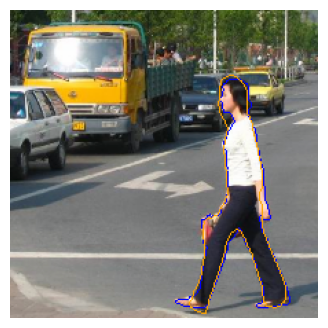

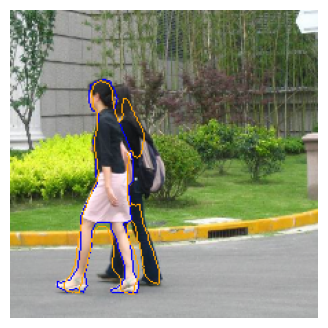

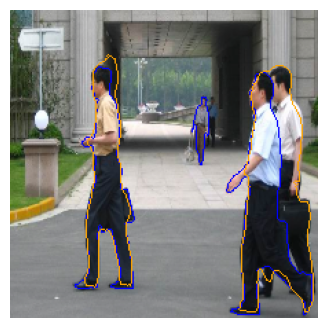

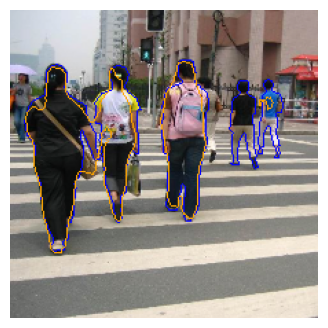

In [8]:
backbone="resnet34"
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"

model = smp.Unet(
    encoder_name=backbone,       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True)

DeepLabV3+ and U-Net are both popular architectures for image segmentation, but they approach the task differently, making them suitable for different kinds of segmentation challenges.

**1. U-Net**  
U-Net is a simpler and more intuitive architecture, particularly popular in medical image segmentation. It uses an encoder-decoder structure:
- **Encoder**: It gradually downsamples the image, capturing spatial features.
- **Decoder**: It upsamples these features to the original image size for pixel-level predictions.
- **Skip Connections**: These connect layers in the encoder to layers in the decoder at the same spatial resolution, helping retain fine details lost during downsampling.
  
U-Net is generally effective for tasks requiring accurate segmentation of small objects and fine details.

**2. DeepLabV3+**  
DeepLabV3+ is a more complex model designed for high-performance segmentation on complex scenes:
- **Atrous Convolutions**: Instead of straightforward downsampling, DeepLabV3+ uses "atrous" or "dilated" convolutions in the encoder, which let the model capture larger context without losing resolution.
- **Atrous Spatial Pyramid Pooling (ASPP)**: This module captures features at multiple scales by applying convolutions with different dilation rates, improving segmentation on objects of varying sizes.
- **Improved Decoder**: The "plus" in DeepLabV3+ refers to an enhanced decoder that sharpens the boundaries of segmented objects, helping the model perform better on fine details.

**Key Differences**  
- **Context Awareness**: DeepLabV3+ is better at capturing the broader context (useful for natural scene segmentation), whereas U-Net focuses more on fine details and is often preferred for smaller, focused regions like those in medical images.
- **Complexity and Performance**: DeepLabV3+ is generally more complex and computationally intensive than U-Net, so it may require more resources for training and deployment.

In [9]:
backbone="resnet50"
checkpoint_file = MODELS_PATH / "L06_deeplabv3p_resnet50_pennfudan.pth"

# Initialize DeepLabV3+ model with a ResNet-50 backbone
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",       # Choose ResNet-50 as the backbone
    encoder_weights="imagenet",    # Use ImageNet pretrained weights
    in_channels=3,                 # RGB images have 3 channels
    classes=1                      # Binary segmentation (person vs background)
)

device = get_device()

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.AdamW(model.parameters(), lr=0.001)

score_funcs = {"IOU": jaccard_score}

num_epochs = 10
results = train_network(model, 
                        loss_fn,
                        train_loader, 
                        optimizer=optimizer,
                        val_loader=val_loader, 
                        device=device, 
                        checkpoint_file=checkpoint_file,
                        epochs=num_epochs,
                        early_stop_metric="loss",
                        patience=2,
                        score_funcs=score_funcs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\pretrained\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.6MB/s]
Epoch: 100%|██████████| 10/10 [00:55<00:00,  5.59s/it]


C:\Users\bagge\AppData\Local\Temp\ipykernel_31480\125162087.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_mask = torch.sigmoid(torch.tensor(logits)).numpy()


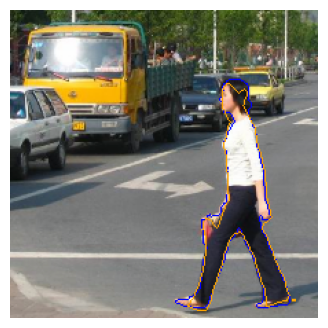

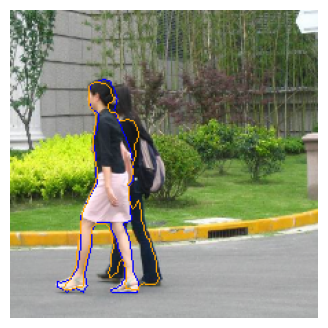

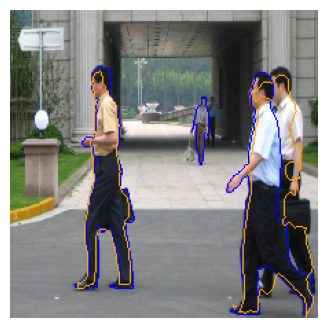

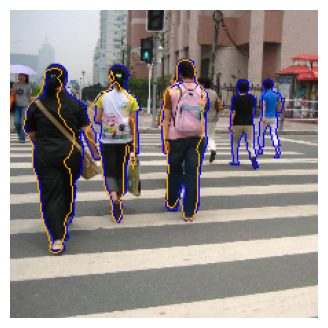

In [11]:
backbone="resnet50"
checkpoint_file = MODELS_PATH / "L06_deeplabv3p_resnet50_pennfudan.pth"

# Initialize DeepLabV3+ model with a ResNet-50 backbone
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",       # Choose ResNet-50 as the backbone
    encoder_weights="imagenet",    # Use ImageNet pretrained weights
    in_channels=3,                 # RGB images have 3 channels
    classes=1                      # Binary segmentation (person vs background)
)

model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True)